# Get partial correlation data from PNC for study

via nilearn<br>
and compare with nilearn correlation?

In [1]:
# Using newly preprocessed subjects

import pickle

metadictname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_agesexwrat.pkl'
alltsname = '/home/anton/Documents/Tulane/Research/PNC_Good/PNC_PowerTS_float2.pkl'

with open(metadictname, 'rb') as f:
    metadict = pickle.load(f)

with open(alltsname, 'rb') as f:
    allts = pickle.load(f)
    
print(list(metadict.keys()))
print(list(allts.keys()))
print('Complete')

['age', 'sex', 'wrat', 'missingage', 'missingsex', 'missingwrat', 'failedqc']
['emoid', 'nback', 'rest']
Complete


In [2]:
'''
Get subjects that have all tasks and paras specified
Functions for creating independent and response variables
'''

import numpy as np

def get_subs(allts, metadict, tasks, paras):
    # Get subs for all paras
    for i,para in enumerate(paras):
        tmpset = set([int(sub[4:]) for sub in allts[para].keys()])
        if i == 0:
            paraset = tmpset
        else:
            paraset = paraset.intersection(tmpset)
    # Get subs for all tasks
    for i,task in enumerate(tasks):
        tmpset = set([sub for sub in metadict[task].keys()])
        if i == 0:
            taskset = tmpset
        else:
            taskset = paraset.intersection(tmpset)
    # Remove QC failures
    allsubs = taskset.intersection(paraset)
    for badsub in metadict['failedqc']:
        try:
            allsubs.remove(int(badsub[4:]))
        except:
            pass
    return list(allsubs)

def get_X(allts, paras, subs):
    X = []
    for para in paras:
        pX = [allts[para][f'sub-{sub}'] for sub in subs]
        pX = np.stack(pX)
        X.append(pX)
    return X

def get_y(metadict, tasks, subs):
    y = []
    for task in tasks:
        if task == 'age' or task == 'wrat':
            var = [metadict[task][sub] for sub in subs]
            var = np.array(var)
            y.append(var)
        if task == 'sex':
            maleness = [metadict[task][sub] == 'M' for sub in subs]
            maleness = np.array(maleness)
            sex = np.stack([maleness, 1-maleness], axis=1)
            y.append(sex)
    return y

subs = get_subs(allts, metadict, ['wrat'], ['rest', 'nback', 'emoid'])
print(len(subs))

X = get_X(allts, ['rest', 'nback', 'emoid'], subs)
print(X[0].shape)

830
(830, 264, 124)


In [4]:
# TS to condensed FC

from scipy import signal

def butter_bandpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = [cutoff[0] / nyq, cutoff[1] / nyq]
    b, a = signal.butter(order, normal_cutoff, btype='band', analog=False)
    return b, a

def butter_bandpass_filter(data, cutoff, fs, order=5):
    b, a = butter_bandpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

tr = 3

def filter_design_ts(X):
    Xs = []
    for i in range(X.shape[0]):
        nX = butter_bandpass_filter(X[i], [0.01, 0.15], 1/tr)
        Xs.append(nX)
    return np.stack(Xs)

def ts_to_flat_fc(X):
    p = np.corrcoef(X)
    a,b = np.triu_indices(p[0].shape[0], 1)
    p = p[a,b]
    return p

X = [np.stack([ts for ts in filter_design_ts(Xp)]) for Xp in X]
# Xfiltnorm = [tsmod/np.linalg.norm(tsmod, axis=(-1), keepdims=True) for tsmod in ts]
print(X[0].shape)

(830, 264, 124)


In [5]:
from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind='partial correlation')

pnp = np.corrcoef(X[0][10])
pcm = cm.fit_transform(X[0][10:11].transpose(0,2,1))[0]
md = np.arange(264)
pcm[md,md] = 0

print(pnp.shape)
print(pcm.shape)

(264, 264)
(264, 264)


In [6]:
cm = ConnectivityMeasure(kind='partial correlation')

# NOTE tril indices!
pcm3 = cm.fit_transform(X[0][0:50].transpose(0,2,1))
a,b = np.triu_indices(264, 1)
pvec = pcm3[10,a,b]
pcm2 = np.zeros((264,264))
pcm2[a,b] = pvec
pcm2 = pcm2 + pcm2.T

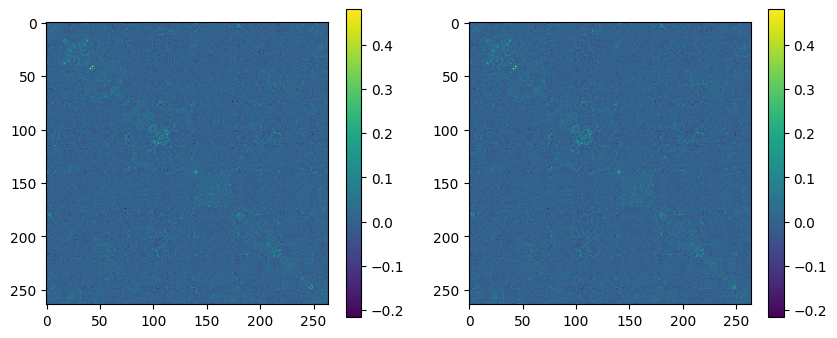

In [7]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(10,4))
im0 = ax[0].imshow(pcm2)
im1 = ax[1].imshow(pcm)
fig.colorbar(mappable=im0, ax=ax[0])
fig.colorbar(mappable=im1, ax=ax[1])
fig.show()

In [32]:
# Get and save all partial correlations

partdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/test/partial'
taskidx = 2
task = 'emoid'

cm = ConnectivityMeasure(kind='partial correlation')

a,b = np.triu_indices(264, 1)

partials = cm.fit_transform(X[taskidx].transpose(0,2,1))
partials = partials[:,a,b]
print('Done partials')

for i,sub in enumerate(subs):
    fname = f'{partdir}/{sub}_task-{task}_partial.npy'
    np.save(fname, partials[i])
    
print('Done saving')

Done partials
Done saving


In [41]:
# Check prediction using partials

import torch
import torch.nn as nn

mseLoss = nn.MSELoss()

ntrain = 700
idcs = torch.randperm(partials.shape[0])

x = torch.from_numpy(partials).float().cuda()
x = x[idcs]
xtr = x[:ntrain]
xt = x[ntrain:]

y = get_y(metadict, ["age"], subs)[0]
y = torch.from_numpy(y).float().cuda()
y = y[idcs]
ytr = y[:ntrain]
yt = y[ntrain:]
mu = torch.mean(ytr)
ytr = ytr - mu
yt = yt - mu

w, _, _, _ = torch.linalg.lstsq(xtr, ytr)
yhat = xt@w
print(mseLoss(yhat, yt)**0.5)

tensor(25.4161, device='cuda:0')
